<a href="https://colab.research.google.com/github/rociohbarroso/Python/blob/main/Prueba2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 1 images belonging to 2 classes.
Found 1 images belonging to 2 classes.


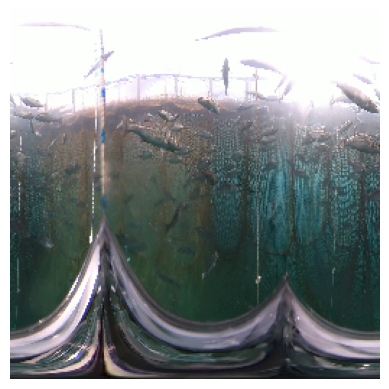

1/1 [==============================] - 23s 23s/step - loss: 1.4732


ModuleNotFoundError: No module named 'keras.layers.advanced_activations'

In [ ]:

#pip install tensorflow
#pip install keras
#pip install imgaug
#pip install opencv-python
#pip install h5py
#pip install tqdm
#pip install imutils

import argparse
import numpy as np
import json
import cv2
import copy
import imgaug as ia
from imgaug import augmenters as iaa
from keras.utils import Sequence
import xml.etree.ElementTree as ET


import os
imagenes_path = "/imagenes"
anotaciones_path="/anotaciones"

trainval = open(os.path.join(anotaciones_path,"documento.xml")).readlines()
os.makedirs(os.path.join(imagenes_path,"train","lubinas"), exist_ok=True)

def classify_image(line, subset):
  basename = line.split(" ")[0]
  species = line.split(" ")[2]
  oldpath = os.path.join(imagenes_path, f"{basename}.jpg")
  newpath = os.path.join(imagenes_path, subset, f"{basename}.jpg")
  if os.path.isfile(oldpath):
        os.rename(oldpath, newpath)


from tensorflow.keras.preprocessing.image import ImageDataGenerator

generador_entrenamiento = ImageDataGenerator()
datos_entrenamiento = generador_entrenamiento.flow_from_directory("/imagenes/")
generador_test = ImageDataGenerator()
datos_test = generador_test.flow_from_directory("/imagenes/", class_mode=None)
algunas_imagenes = next(datos_test)



from matplotlib import pyplot as plt
plt.imshow(algunas_imagenes[0]/255.)
plt.axis('off')
plt.show()



from tensorflow.keras import applications
inception = applications.InceptionV3(include_top=False, input_shape=(256, 256, 3))

from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Sequential
predictor = Sequential([
    Flatten(),
    Dense(128, activation="relu"),
    Dense(2, activation="softmax")
])
modelo = Sequential([inception, predictor])
modelo.compile(optimizer="adam", loss="categorical_crossentropy")

modelo.fit(datos_entrenamiento, epochs=1)

def bbox_iou(box1, box2):
  intersect_w = _interval_overlap([box1.xmin, box1.max], [box2.xmin, box2.max])
  intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.yax])

  intersect = intersect_w * intersect_h

  w1,h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
  w2,h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

  union = w1*h1 + w2*h2 - intersect

  return float(intersect) / union

class BoundBox:
  def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
    self.xmin = xmin
    self.ymin = ymin
    self.xmax = xmax
    self.ymax = ymax
    self.c = c
    self.classes = classes
    self.label = -1
    self.score = -1

  def get_label(self):
    if self.label == -1:
      self.label = np.argmax(self.classes)
    return self.label

  def get_score(self):
    if self.score == -1:
      self.score = self.classes[self.get_label()]
    return self.score

class BatchGenerator(Sequence):
  def __init__(self, images, config, shuffle=True, jitter=True, norm=None):
    self.generator = None
    self.images = images
    self.config = config
    self.shuffle = shuffle
    self.jitter = jitter
    self.norm = norm
    self.anchors = [BoundBox(0, 0, config['ANCHORS'][2*i], config['ANCHORS'][2*i+1]) for i in range(int(len(config['ANCHORS'])//2))]

    sometimes = lambda aug: iaa.Sometimes(0.5,aug)

    self.aug_pipe = iaa.Sequential(
        [
            sometimes(iaa.Affine()),
            iaa.SomeOf((0,5),
                [
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 3.0)),
                        iaa.AverageBlur(k=(2,7)),
                        iaa.MedianBlur(k=(3,11)),
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0,0.05*255),per_channel=0.5),
                    iaa.OneOf([
                        iaa.Dropout((0.01,0.1), per_channel=0.5),
                    ]),
                    iaa.Add((-10,10), per_channel=0.5),
                    iaa.Multiply((0.5,1.5), per_channel=0.5),
                    iaa.ContrastNormalization((0.5,2.0), per_channel= 0.5),
                ],
                random_order = True
            )
        ],
        random_order = True
    )
    if shuffle: np.random.shuffle(self.images)

  def __len__(self):
    return int(np.cel(float(len(self.images))/self.config['BATCH_SIZE']))

  def num_classes(self):
    return len(self.config['LABELS'])

  def size(self):
    return len(self.images)

  def load_annotation(self, i):
    annots = []

    for obj in self.images[i]['object']:
      annot = [obj['xmin'], obj['ymin'], obj['xmax'], obj['ymax'], self.config['LABELS'].index(obj['name'])]
      annots += [annot]

    if len(annots) == 0: annots = [[]]
    return np.array(annots)

  def load_images(self, i):
    return cv2.imread(self.images[i]['filename'])

  def __getitem___(self, idx):
    l_bound = idx*self.config['BATCH_SIZE']
    r_bound = (idx+1)*self.config['BATCH_SIZE']

    if r_bound > len(self.images):
      r_bound = len(self.images)
      l_bound = r_bound - self.config['BATCH_SIZE']

    instance_count = 0

    x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_W'],3))
    b_batch = np.zeros((r_bound-l_bound, 1, 1, 1, self.config['TRUE_BOX_BUFFER'],4))
    y_batch = np.zeros((r_bound-l_bound, self.config['GRID_H'], self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))

    for train_instance in self.images[l_bound:r_bound]:
      img,all_objs = self.aug_image(train_instance, jitter=self.jitter)
      true_box_index = 0

      for obj in all_objs:
        if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
              center_x = .5*(obj['xmin'] + obj['xmax'])
              center_x = center_x / (float(self.config['IMAGE_W']) / self.config['GRID_W'])
              center_y = .5*(obj['ymin'] + obj['ymax'])
              center_y = center_y / (float(self.config['IMAGE_H']) / self.config['GRID_H'])

              grid_x = int(np.floor(center_x))
              grid_y = int(np.floor(center_y))

              if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                obj_indx = self.config['LABELS'].index(obj['name'])

                center_w = (obj['xmax']-obj['xmin'])/(float(self.config['IMAGE_W'])/ self.config['GRID_W'])
                center_h = (obj['ymax'] - obj['ymin']) / (float(self.config['IMAGE_H']) / self.config['GRID_H']) # unit: grid cell\n",

                box = [center_x, center_y, center_w, center_h]

                best_anchor = -1
                max_iou     = -1

                shifted_box = BoundBox(0, 0, center_w, center_h)

                for i in range(len(self.anchors)):
                  anchor = self.anchors[i]
                  iou    = bbox_iou(shifted_box, anchor)

                  if max_iou < iou:
                   best_anchor = i
                   max_iou     = iou

                # assign ground truth x, y, w, h, confidence and class probs to y_batch\n",
                y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box
                y_batch[instance_count, grid_y, grid_x, best_anchor, 4  ] = 1.
                y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_indx] = 1

                # assign the true box to b_batch\n",
                b_batch[instance_count, 0, 0, 0, true_box_index] = box

                true_box_index += 1
                true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']

      # assign input image to x_batch\n",
      if self.norm != None:
        x_batch[instance_count] = self.norm(img)
      else:
        # plot image and bounding boxes for sanity check\n",
        for obj in all_objs:
         if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin']:
          cv2.rectangle(img[:,:,::-1], (obj['xmin'],obj['ymin']), (obj['xmax'],obj['ymax']), (255,0,0), 3)
          cv2.putText(img[:,:,::-1], obj['name'], (obj['xmin']+2, obj['ymin']+12), 0, 1.2e-3 * img.shape[0], (0,255,0), 2)

        x_batch[instance_count] = img

      # increase instance counter in current batch\n",
      instance_count += 1

     #print(' new batch created', idx)\n",

    return [x_batch, b_batch], y_batch

  def on_epoch_end(self):
    if self.shuffle: np.random.shuffle(self.images)

  def aug_image(self, train_instance, jitter):
    image_name = train_instance['filename']
    image = cv2.imread(image_name)

    if image is None: print ('Cannot find', image_name)

    h, w,c = image.shape
    all_objs = copy.deepcopy(train_instance['object'])

    if jitter:
      ##scale the image
      scale = np.random.uniform() /10. +1.
      image = cv2.resize(image, (0,0), fx = scale, fy = scale)

      ## translate the image
      max_offx = (scale -1.) * w
      max_offy =(scale-1.)*h
      offx = int(np.random.uniform()* max_offx)
      offy = int(np.random.uiform() * max_offy)

      image = image[offy : (offy + h), offx : (offx + w)]

      ##flip the image
      flip = np.random.binomial(1, 5.)
      if flip> 0.5: image = cv2.flip(image, 1)

      image = self.aug_pipe.aument_image(image)

    ##resize the image to standard size
    image = cv2.resize(image, (self.config['IMAGE_H'], self.config['IMAGE_W']))
    image = image[:,:,::-1]

    #fix object's position and size
    for obj in all_objs:
      for attr in ['xmin', 'xmax']:
        if jitter: obj[attr] = int(obj[attr]*scale - offx)

        obj[attr] = int(obj[attr] * float(self.config['IMAGE_W'])/w)
        obj[attr] = max(min(obj[attr], self.config['IMAGE_W']), 0)

      for attr in ['ymin', 'ymax']:
        if jitter: obj[attr] = int(obj[attr]*scale - offy)

        obj[attr] = int(obj[attr] * float(self.config['IMAGE_H'])/h)
        obj[attr] = max(min(obj[attr], self.config['IMAGE_H']), 0)

      if jitter and flip > 0.5:
        xmin = obj['xmin']
        obj['xmin'] = self.config['IMAGE_W'] - obj['xmax']
        obj['xmax'] = self.config['IMAGE_W'] - xmin

    return image, all_objs

from keras.models import Model
import tensorflow as tf
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

FULL_YOLO_BACKEND_PATH = "full_yolo_backend.h5\ "

class BaseFeatureExtractor(object):
       "\"\"\"docstring for ClassName\"\"\ "

       #to be defined in each subclass
       def __init__(self,input_size):
        raise NotImplementedError("error message\ " )

       #to be define  in each class
       def normalize(self, image):
         raise NotImplementedError("error message\ ")

       def get_output_shape(self):
        return self.feature_extractor.get_output_shape_at(-1)[1:3]


class FullYoloFeature(BaseFeatureExtractorExtractor):
        "\"\"\"docstring for ClassName\"\"\ "
        def __init__(self, input_Size):
          input_image = Input(shape=(input_size, input_size, 3))

          #the function to implement the organization layer
          def space_to_depth_x2(x):
            return tf.space_to_depth(x, block_size=2)

          #Layer 1
          x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
          x = BatchNormalization(name='norm_1')(x)
          x = LeakyReLU(alpha=0.1)(x)
          x = MaxPooling2D(pool_Size=(2, 2))(x)

          #Layer 2
          x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
          x = BatchNormalization(name='norm_2')(x)
          x = LeakyReLU(alpha=0.1)(x)
          x = MaxPooling2D(pool_Size=(2, 2))(x)

          #Layer 3
          x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
          x = BatchNormalization(name='norm_3')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 4
          x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(X)
          x = BatchNormalization(name='norm_4')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 5
          x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
          x = BatchNormalization(name='norm_5')(x)
          x = LeakyReLU(alpha=0.1)(x)
          x = MaxPooling2D(pool_Size=(2, 2))(x)

          #Layer 6
          x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
          x = BatchNormalization(name='norm_6')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 7
          x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
          x = BatchNormalization(name='norm_7')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 8
          x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
          x = BatchNormalization(name='norm_8')(x)
          x = LeakyReLU(alpha=0.1)(x)
          x = MaxPooling2D(pool_Size=(2, 2))(x)

          #Layer 9
          x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
          x = BatchNormalization(name='norm_9')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 10
          x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
          x = BatchNormalization(name='norm_10')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 11
          x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
          x = BatchNormalization(name='norm_11')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 12
          x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
          x = BatchNormalization(name='norm_12')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 13
          x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
          x = BatchNormalization(name='norm_13')(x)
          x = LeakyReLU(alpha=0.1)(x)

          skip_connection = x

          x = MaxPooling2D(pool_size=(2, 2))(x)

          #Layer 14
          x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
          x = BatchNormalization(name='norm_14')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 15
          x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
          x = BatchNormalization(name='norm_15')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 16
          x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
          x = BatchNormalization(name='norm_16')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 17
          x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
          x = BatchNormalization(name='norm_17')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 18
          x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
          x = BatchNormalization(name='norm_18')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 19
          x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
          x = BatchNormalization(name='norm_19')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 20
          x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
          x = BatchNormalization(name='norm_20')(x)
          x = LeakyReLU(alpha=0.1)(x)

          #Layer 21
          skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
          skip_connection = BatchNormalization(name='norm_21')(skip_connection)
          skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
          skip_connection = Lambda(space_to_depth_x2)(skip_connection)

          x = concatenate([skip_connection, x])

          #Layer 22
          x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
          x = BatchNormalization(name='norm_22')(x)
          x = LeakyReLU(alpha=0.1)(x)

          self.feature_extractor = Model(input_image, x)
          self.feature_extractor.load_weights(FULL_YOLO_BACKEND_PATH)

        def normalize(self, image):
          return image / 255.


#funciones que necesitaremos
def _sigmoid(x):
  return 1./(1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
  x = x-np.max(x)

  if np.min(x) < t:
    x = x/np.min(x)*t

  e_x = np.exp(x)

  return e_x / e_x.sum(axis, keepdims=True)

def _interval_overlap(interval_a, interval_b):
  x1, x2 = interval_a
  x3, x4 = interval_b

  if x3 < x1:
    if x4< x1:
      return 0
    else:
      return min(x2,x4) - x1
  else:
    if x2 < x3:
      return 0
    else:
      return min(x2,x4) -x3

def compute_overlap(a,b):

  area = (b[:,2] - b[:, 0]) * (b[:,3] - b[:,1])

  iw = np.minimum(np.expand_dims(a[:,2], axis=1), b[:,2]) - np.maximum(np.expand_dims(a[:,0], 1), b[:,0])
  ih = np.minimum(np.expand_dims(a[:,3], axis=1), b[:,3]) - np.maximum(np.expand_dims(a[:,1], 1), b[:, 1])

  iw = np.maximum(iw, 0)
  ih = np.maximum(ih, 0)

  ua = np.expand_dims((a[:,2] - a[:, 0]) * (a[:,3] - a[:,1]), axis=1) + area - iw * ih

  ua = np.maximum(ua, np.finfo(float).eps)

  intersection = iw * ih

  return intersection / ua

def computer_ap(recall, precision):
  #first append sentinel values at the end
  mrec = np.concatenate(([0.], recall, [1.]))
  mpre = np.concatenate(([0.], precision, [0.]))

  #compute the precision envelope
  for i in range(mpre.size - 1, 0, -1):
    mpre[i - 1]= np.maximum(mpre[i -1], mpre[i])

  #to calculate area under PR curve, look for points
  #where X axis (recall) changes value
  i = np.where(mrec[1:] != mrec[:-1])[0]

  #and sum (\\Delta recall) * prec
  ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
  return ap

def decode_netout(netout, anchors, nb_class, obj_threshold=0.3, nms_threshold=0.3):
  grid_h, grid_w, nb_box = netout.shape[:3]

  boxes = []

  #decode the output by the network
  netout[...,4] = _sigmoid(netout[...,4])
  netout[...,5:] = netout[...,4][..., np.newaxis] * _



















